# Capstone Project: Shoe Image Classifer and Logo Detector

Outline
- Problem Statement
- EDA
- Modelling
    - Transfer learning model `MobileNetV2`
    - Object Detection using `YOLOv5` model
- [Evaluation](#Evaluation)
- [Deployment](#Deployment)
- [Conclusion](#Conclusion)

- <a href = './EDA&Modelling.ipynb'> Click for the previous notebook on EDA and Modelling </a>

## Evaluation

- Both the classification and object detection models are evaluated using some test images

In [5]:
import numpy as np

from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import yolov5

In [3]:
#store the shoe brand
brands = {'adidas': 0, 'converse': 1, 'nike': 2}

In [1]:
#helper function to predict the shoe images and decode the shoe brand and probability from the predicted result
def predict_image(model_name, img_name, input_dict):
    #load the saved classification model
    model_path = '../assets/' + model_name
    mobilenet_model = load_model(model_path)
    
    #load an image for prediction into Python
    img_path = '../assets/' + img_name
    test_image = image.load_img(img_path)
    
    #convert the image to a matrix of numbers to feed into model
    test_image = image.img_to_array(test_image) # 1st: convert loaded image to array

    # 2nd: https://www.tensorflow.org/api_docs/python/tf/expand_dims 
    #(to add additional 4th dummy dimension for batch on top of height, width, channel for a color image, 
    # to meet Tensorflow's expected no. of dimensions for input image
    test_image = np.expand_dims(test_image, axis=0)

    test_image = preprocess_input(test_image) # 3rd: to pre-process inputs to be in the same format expected by MobileNetV2
    
    #make predictions
    result = mobilenet_model.predict(test_image) 
    
    #return predicted brand and probability in the list of tuples [(predicted brand, prob)]
    return [(i, np.max(result)) for i, j in input_dict.items() if j == np.argmax(result)]

In [6]:
#load Adidas shoe image and predict
img1 = predict_image('mobilenet_model.h5','aadidas_ (3).jpg', brands)

1/1 [==============================] - 1s 899ms/step


In [7]:
img1[0][0]

'adidas'

In [8]:
round(img1[0][1],4)

0.9084

In [9]:
#load Converse shoe image and predict
img2 = predict_image('mobilenet_model.h5','converse1.jpg', brands)

1/1 [==============================] - 1s 801ms/step


In [10]:
img2[0][0]

'converse'

In [11]:
round(img2[0][1],4)

0.9795

In [12]:
#load Nike shoe image and predict
img3 = predict_image('mobilenet_model.h5','Image_10.jpg', brands)

1/1 [==============================] - 1s 818ms/step


In [13]:
img3[0][0]

'nike'

In [14]:
round(img3[0][1],4)

0.587

In [20]:
#helper function to run the custom trained object detection model
def detect_logo(weight_name, img_name):
    # load pretrained model
    weight_path = '../assets/'+weight_name
    model = yolov5.load(wgt)    
    
    # set model parameters
    model.conf = 0.25  # NMS confidence threshold
    model.iou = 0.45  # NMS IoU threshold
    model.agnostic = False  # NMS class-agnostic
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image

    # set image
    img = '../assets/'+img_name

    # perform inference
    results = model(img)
    
    # inference with larger input size
    results = model(img, size=1280)
    
    # inference with test time augmentation
    results = model(img, augment=True)

    # parse results
    predictions = results.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    scores = predictions[:, 4]
    categories = predictions[:, 5]

    # show detection bounding boxes on image
    results.show()
    #results.save(save_dir='results/')

YOLOv5  2022-11-11 Python-3.9.13 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 214 layers, 7027720 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


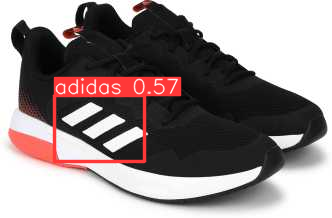

YOLOv5  2022-11-11 Python-3.9.13 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 214 layers, 7027720 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


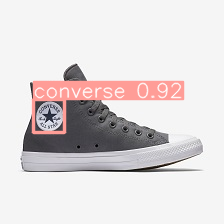

YOLOv5  2022-11-11 Python-3.9.13 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 214 layers, 7027720 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


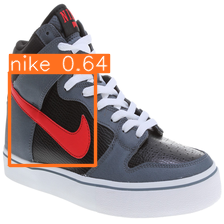

In [21]:
detect_logo('logov1.pt','aadidas_ (3).jpg')
detect_logo('logov1.pt','converse1.jpg')
detect_logo('logov1.pt','Image_10.jpg')

YOLOv5  2022-11-11 Python-3.9.13 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 214 layers, 7027720 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


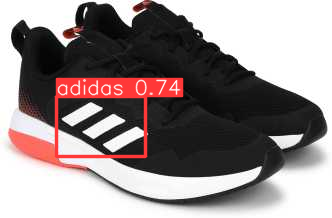

YOLOv5  2022-11-11 Python-3.9.13 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 214 layers, 7027720 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


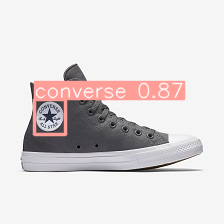

YOLOv5  2022-11-11 Python-3.9.13 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 214 layers, 7027720 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


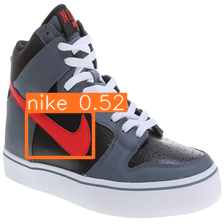

In [10]:
detect_logo('logov7.pt','aadidas_ (3).jpg')
detect_logo('logov7.pt','converse1.jpg')
detect_logo('logov7.pt','Image_10.jpg')

## Deployment

**Description of app flow**

- User input: Users upload shoe images, and click the predict button
- Process: The model will process the uploaded images and predict the brand of the shoes based on the image classification model and detect the brand logos using the custom trained object detection model
- Output: The predicted brand name and associated probability, brand logos with bounding boxes and confidence

In [15]:
%%writefile inference.py
from flask import Flask, request, render_template
import os
import numpy as np
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import yolov5

#Instantiate Flask
api = Flask(__name__)

mobilenet_model = load_model('./best_estimator/mobilenet_model.h5')

#Create the routes
@api.route('/',methods = ['GET'])
def hello():
    # return index.html landing page
    return render_template('index.html')

#route 2: accept input data
#Post method is used when we want to receive some data from the user
@api.route('/predict', methods = ['POST'])
def make_predictions():
    #Image Classifier
    #Get the data sent over the API
    imagefile = request.files['imagefile']
    image_path = './user_input_images/'+imagefile.filename
    imagefile.save(image_path)    
    test_image = image.load_img(image_path)
    
    #convert the image to a matrix of numbers to feed into model
    test_image = image.img_to_array(test_image) # 1st: convert loaded image to array
    
    #2nd: https://www.tensorflow.org/api_docs/python/tf/expand_dims 
    #(to add additional 4th dummy dimension for batch on top of height, width, channel for a color image, 
    #to meet Tensorflow's expected no. of dimensions for input image
    test_image = np.expand_dims(test_image, axis=0)
    
    #3rd: to pre-process inputs to be in the same format expected by MobileNetV2
    test_image = preprocess_input(test_image) 
    result = mobilenet_model.predict(test_image) 
    brands = {'adidas': 0, 'converse': 1, 'nike': 2}
    result = [(i, np.max(result)) for i, j in brands.items() if j == np.argmax(result)]
    
    #object detection
    weight_path = './best_estimator/'+'logov7.pt'
    model = yolov5.load(weight_path)    
       
    #set model parameters
    model.conf = 0.25  # NMS confidence threshold
    model.iou = 0.45  # NMS IoU threshold
    model.agnostic = False  # NMS class-agnostic
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image

    # set image
    img = image_path

    # perform inference
    results = model(img)
    
    # inference with larger input size
    results = model(img, size=1280)
    
    # inference with test time augmentation
    results = model(img, augment=True)

    # parse results
    predictions = results.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    scores = predictions[:, 4]
    categories = predictions[:, 5]

    # show detection bounding boxes on image, save to 'static' folder, set exist_ok to True to prevent creating duplicate folders
    results.save(save_dir='static/', exist_ok=True)
    
    return render_template('index.html', pred_brand = str(result[0][0]), pred_conf = str(round(result[0][1],4)), image='/static/'+str(results.files[0]))

#Main function that actually runs the API!
if __name__ == '__main__':
    api.run(host='0.0.0.0', 
            debug=True, # Debug=True ensures any changes to inference.py automatically updates the running API
            port=int(os.environ.get("PORT", 8080))
           ) 

Overwriting inference.py


![](../images/app.gif)

## Conclusion

- Our project have successfully deployed an image classification model to classify shoe images with accuracy of 0.73, and a custom object detection model to detect logos with `mAP_0.5` of 0.78. When combined with a selling price below a preset threshold, the listings of counterfeit shoes/advertisements can be proactively blocked from being posted/displayed in the search results and also allow for flagging of suspicious product listings for review by the online merchant. 
- It is recommended to use predictions from both models for our use case, with more weightage given to the logo detector as it has a better metric

**Future work**
- Improve on preprocessing. Auto background removal
- More tuning on the weightage from each models
- More image data
